# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize as imresize
from imageio import imread
import datetime
import os

In [ ]:
## Checking the GPU configuration
!nvidia-smi

Tue Sep 13 07:33:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!unzip "/content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data.zip" -d "/content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
#from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data/val.csv').readlines())
batch_size = 20#experiment with the batch size

In [ ]:
train_doc[0]

'WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size,img_height=160,img_width=160,channels = 2):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,26, 27, 29]
     #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image_resized=imresize(image,(img_height,img_width,channels))
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem =len(t)%batch_size
        if rem != 0:
          batch_size = len(t)//batch_size
          num_batches = len(source_path)%batch_size # calculate the number of batches
          for batch in range(num_batches): # we iterate over the number of batches
              batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
              batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
              for folder in range(batch_size): # iterate over the batch_size
                  imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                  for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      #crop the images and resize them. Note that the images are of 2 different shape 
                      #and the conv3D will throw error if the inputs in a batch have different shapes
                      image_resized=imresize(image,(img_height,img_width,channels))
                      batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                      batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                      batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                  batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
              yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data/train'
val_path = '/content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import LSTM
from keras.applications import mobilenet

In [ ]:
Input_shape = (20, 160, 160, 3)
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same',input_shape=Input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,160,160,3)
val_generator = generator(val_path, val_doc, batch_size,160,160,3)

In [ ]:
model_name = 'model_init' + 'base' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath =  model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 4,
  verbose = 1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.2431 - categorical_accuracy: 0.5152Source path =  /content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data/val ; batch size = 20

Epoch 1: saving model to model_initbase2022-09-1307_50_08.790852/model-00001-1.24310-0.51515-2.88627-0.19000.h5
34/34 [==============================] - 803s 24s/step - loss: 1.2431 - categorical_accuracy: 0.5152 - val_loss: 2.8863 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.9173 - categorical_accuracy: 0.6379
Epoch 2: saving model to model_initbase2022-09-1307_50_08.790852/model-00002-0.91733-0.63793-2.31522-0.38000.h5
34/34 [==============================] - 266s 8s/step - loss: 0.9173 - categorical_accuracy: 0.6379 - val_loss: 2.

In [ ]:
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])  

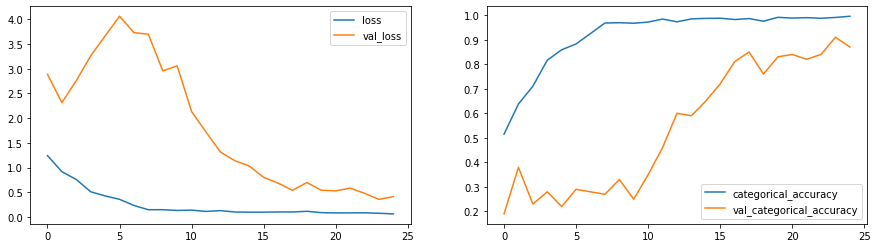

In [ ]:
plot(history1)

### **CNN + RNN with LSTM model**

In [ ]:
img_height = 128
img_width = 128
channels = 3
Input_shape = (20, img_height, img_width, channels)
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:

optimiser = tf.keras.optimizers.Adam(lr=0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 128, 128, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 128, 128, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 64, 64, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 64, 64, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 64, 64, 32)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, img_height, img_width,channels)
val_generator = generator(val_path, val_doc, batch_size, img_height, img_width,channels)

model_name = 'model_init' + 'cnn_LSTM' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath =  model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.0679 - categorical_accuracy: 0.9854
Epoch 1: saving model to model_initcnn_LSTM2022-09-1315_08_34.185409/model-00001-0.06793-0.98542-0.54571-0.81000.h5
34/34 [==============================] - 255s 8s/step - loss: 0.0679 - categorical_accuracy: 0.9854 - val_loss: 0.5457 - val_categorical_accuracy: 0.8100 - lr: 1.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.0632 - categorical_accuracy: 0.9899
Epoch 2: saving model to model_initcnn_LSTM2022-09-1315_08_34.185409/model-00002-0.06319-0.98986-0.48136-0.83000.h5
34/34 [==============================] - 260s 8s/step - loss: 0.0632 - categorical_accuracy: 0.9899 - val_loss: 0.4814 - val_categorical_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0552 - categorical_accuracy: 0.9870
Epoch 3: saving model to model_initcnn_LSTM2022-09-1315_08_34.185409/model-00003-0.05518-0.98704-0.49718-0.8

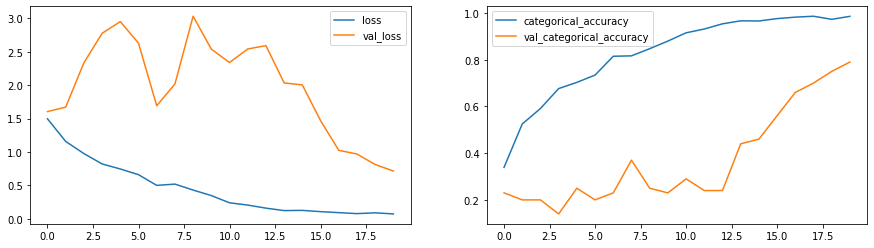

In [ ]:
plot(history_1)

###**CNN + RNN with GRU Model**

In [ ]:
img_height = 128
img_width = 128
channels = 3
Input_shape = (20, img_height, img_width, channels)
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:

optimiser = tf.keras.optimizers.Adam(lr=0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 128, 128, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 64, 64, 32)   1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, img_height, img_width,channels)
val_generator = generator(val_path, val_doc, batch_size, img_height, img_width,channels)

model_name = 'model_init' + 'RNN_GRU' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath =  model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 0.0746 - categorical_accuracy: 0.9854
Epoch 1: saving model to model_initRNN_GRU2022-09-1315_20_22.398211/model-00001-0.07462-0.98542-0.60825-0.79000.h5
34/34 [==============================] - 198s 6s/step - loss: 0.0746 - categorical_accuracy: 0.9854 - val_loss: 0.6083 - val_categorical_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.0682 - categorical_accuracy: 0.9876
Epoch 2: saving model to model_initRNN_GRU2022-09-1315_20_22.398211/model-00002-0.06823-0.98761-0.60241-0.80000.h5
34/34 [==============================] - 221s 7s/step - loss: 0.0682 - categorical_accuracy: 0.9876 - val_loss: 0.6024 - val_categorical_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.0689 - categorical_accuracy: 0.9823
Epoch 3: saving model to model_initRNN_GRU2022-09-1315_20_22.398211/model-00003-0.06892-0.98233-0.45038-0.8300

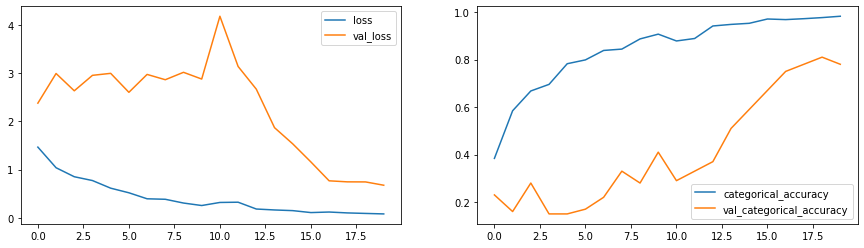

In [ ]:
plot(history_1)

### **Transfered Learning with GRU using Mobilenet Model**

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
Input_shape = (20, 128, 128, 3)
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=Input_shape))


model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 20, 4, 4, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 4, 4, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 2, 2, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 4096)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,128,128,3)
val_generator = generator(val_path, val_doc, batch_size,128,128,3)

model_name = 'model_init' + 'base' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath =  model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 4,
  verbose = 1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.0531 - categorical_accuracy: 0.5815  Source path =  /content/drive/Othercomputers/My Laptop (1)/Upgrad DS/Deep Learning/Gesture Recognization/Project_data/val ; batch size = 20

Epoch 1: saving model to model_initbase2022-09-1316_16_12.232291/model-00001-1.05311-0.58153-0.86416-0.63000.h5
34/34 [==============================] - 10834s 328s/step - loss: 1.0531 - categorical_accuracy: 0.5815 - val_loss: 0.8642 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.2715 - categorical_accuracy: 0.8966
Epoch 2: saving model to model_initbase2022-09-1316_16_12.232291/model-00002-0.27150-0.89655-0.38499-0.84000.h5
34/34 [==============================] - 275s 8s/step - loss: 0.2715 - categorical_accuracy: 0.8966 - val_los

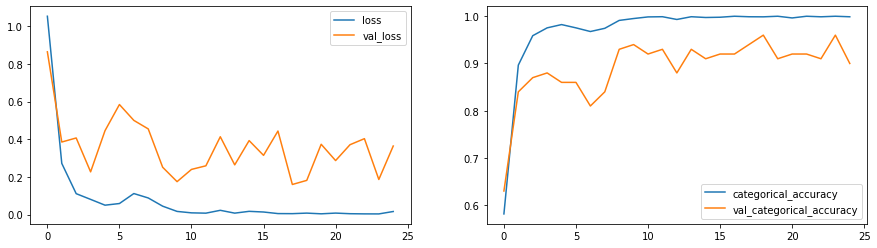

In [ ]:
plot(history1)